# IS 4487 Assignment 9: Customer Segmentation with Clustering

In this assignment, you will:
- Apply unsupervised learning to explore patterns in hotel booking behavior
- Use K-Means and Gaussian Mixture Models (GMM) for customer segmentation
- Evaluate model quality with metrics like Silhouette Score and Davies-Bouldin Index
- Connect clustering to actionable business insights

## Why This Matters

Businesses like hotels and travel platforms (e.g., Airbnb or Expedia) rely on customer segmentation to tailor promotions, pricing strategies, and service levels. Unlike supervised models, clustering helps uncover patterns when no labels exist—an ideal tool when entering new markets or analyzing unstructured customer behavior.

<a href="https://colab.research.google.com/github/Stan-Pugsley/is_4487_base/blob/main/Assignments/assignment_09_clustering.ipynb" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


## Dataset Description: Hotel Bookings

This dataset contains booking information for two types of hotels: a **city hotel** and a **resort hotel**. Each record corresponds to a single booking and includes various details about the reservation, customer demographics, booking source, and whether the booking was canceled.

**Source**: [GitHub - TidyTuesday: Hotel Bookings](https://github.com/rfordatascience/tidytuesday/blob/master/data/2020/2020-02-11/readme.md)

### Key Use Cases
- Understand customer booking behavior
- Explore factors related to cancellations
- Segment guests based on booking characteristics
- Compare city vs. resort hotel performance

### Data Dictionary

| Variable | Type | Description |
|----------|------|-------------|
| `hotel` | character | Hotel type: City or Resort |
| `is_canceled` | integer | 1 = Canceled, 0 = Not Canceled |
| `lead_time` | integer | Days between booking and arrival |
| `arrival_date_year` | integer | Year of arrival |
| `arrival_date_month` | character | Month of arrival |
| `stays_in_weekend_nights` | integer | Nights stayed on weekends |
| `stays_in_week_nights` | integer | Nights stayed on weekdays |
| `adults` | integer | Number of adults |
| `children` | integer | Number of children |
| `babies` | integer | Number of babies |
| `meal` | character | Type of meal booked |
| `country` | character | Country code of origin |
| `market_segment` | character | Booking source (e.g., Direct, Online TA) |
| `distribution_channel` | character | Booking channel used |
| `is_repeated_guest` | integer | 1 = Repeated guest, 0 = New guest |
| `previous_cancellations` | integer | Past booking cancellations |
| `previous_bookings_not_canceled` | integer | Past bookings not canceled |
| `reserved_room_type` | character | Initially reserved room type |
| `assigned_room_type` | character | Room type assigned at check-in |
| `booking_changes` | integer | Number of booking modifications |
| `deposit_type` | character | Deposit type (No Deposit, Non-Refund, etc.) |
| `agent` | character | Agent ID who made the booking |
| `company` | character | Company ID (if booking through company) |
| `days_in_waiting_list` | integer | Days on the waiting list |
| `customer_type` | character | Booking type: Contract, Transient, etc. |
| `adr` | float | Average Daily Rate (price per night) |
| `required_car_parking_spaces` | integer | Requested parking spots |
| `total_of_special_requests` | integer | Number of special requests made |
| `reservation_status` | character | Final status (Canceled, No-Show, Check-Out) |
| `reservation_status_date` | date | Date of the last status update |

This dataset is ideal for classification, segmentation, and trend analysis exercises.

## 1. Setup and Load Data

Business framing:  

Before we can cluster or segment anything, we need clean, accessible data in a usable format.

- Import the necessary Python libraries
- Load the hotel bookings dataset by [downloading the file](https://github.com/rfordatascience/tidytuesday/blob/main/data/2020/2020-02-11/readme.md#get-the-data-here) or using this link: https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2020/2020-02-11/hotels.csv
- Display the first few rows

### In Your Response:
1. What stands out in the initial preview? Any columns or rows that seem unusual?

In [40]:
# Add code here 🔧
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score

#file
url = 'https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2020/2020-02-11/hotels.csv'
df = pd.read_csv(url)

#first few rows
df.head(5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

### ✍️ Your Response: 🔧
1. Some things I noticed is that the children, agent, and company collumns shouldn't be floats, and the reservation variable should be time series. Also, company has a lot of null values (agent as well).

## 2. Select and Prepare Features

Business framing:  

A hotel might want to group guests based on how long they stay, how far in advance they book, or how likely they are to make special requests. You need to pick variables that represent meaningful guest behavior.

- Choose 3–5 numeric features related to customer behavior
- Drop missing values if needed
- Standardize using `StandardScaler`

### In Your Response:
1. What features did you select and why?
2. What kinds of patterns or segments do you expect to find?


In [42]:
# Add code here 🔧
df["total_nights"] = df["stays_in_weekend_nights"] + df["stays_in_week_nights"]
new_features = ['total_nights', 'lead_time', 'total_of_special_requests']
df = df.dropna(subset = new_features)

df["lead_time"] = df["lead_time"].astype(int)
df["total_of_special_requests"] = df["total_of_special_requests"].astype(int)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 33 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [43]:
#scale
segment_df = df[new_features].copy()
scaler = StandardScaler()
scaled_data = scaler.fit_transform(segment_df)
segment_scaled = pd.DataFrame(scaled_data, columns = new_features)
segment_scaled.head()

,total_nights,lead_time,total_of_special_requests
0,-1.340370,2.227051,-0.720694
1,-1.340370,5.923385,-0.720694
2,-0.949352,-0.907814,-0.720694
3,-0.949352,-0.851667,-0.720694
4,-0.558334,-0.842309,0.540666


### ✍️ Your Response: 🔧
1. The features I selected were total_nights (weekend nights and weekday nights), lead_time, and total_of_special_requests. I chose them because it is useful for businesses and are deciding factors for customers so it is useful to group them.

2. In total_nights I expect to find segments for those who stay for a small time (tourists), and those that stay for a longer time (long-term customers like business of students). In lead_time, I expect to find segments for those who book long before hand (tourists?) and those who book last minute (businesses?). In total_of_special_requests, I expect that they are few and far between.


## 3. Apply K-Means Clustering

Business framing:  

Let’s say you’re working with the hotel’s marketing manager. She wants to group guests into a few clear types to target email campaigns. K-Means is a fast, simple way to try this.

- Fit a `KMeans` model with your selected features
- Choose a value of `k` (e.g. 3, 4, or 5)
- Predict clusters and assign to each guest
- Visualize using a scatterplot of 2 features

Much of this assignment has already been covered in the lab. Please be sure to complete the lab before the assignment.

### In Your Response:
1. What `k` value did you choose, and how did you decide?
2. What types of customers seem to show up in the clusters?



In [44]:
# Add code here 🔧
x_features = segment_scaled.copy()

kmeans_features = KMeans(n_clusters = 3, random_state = 1)
segment_scaled['cluster'] = kmeans_features.fit_predict(x_features)
segment_scaled['cluster'].value_counts()

,count
cluster,
0,49621
1,41882
2,27887


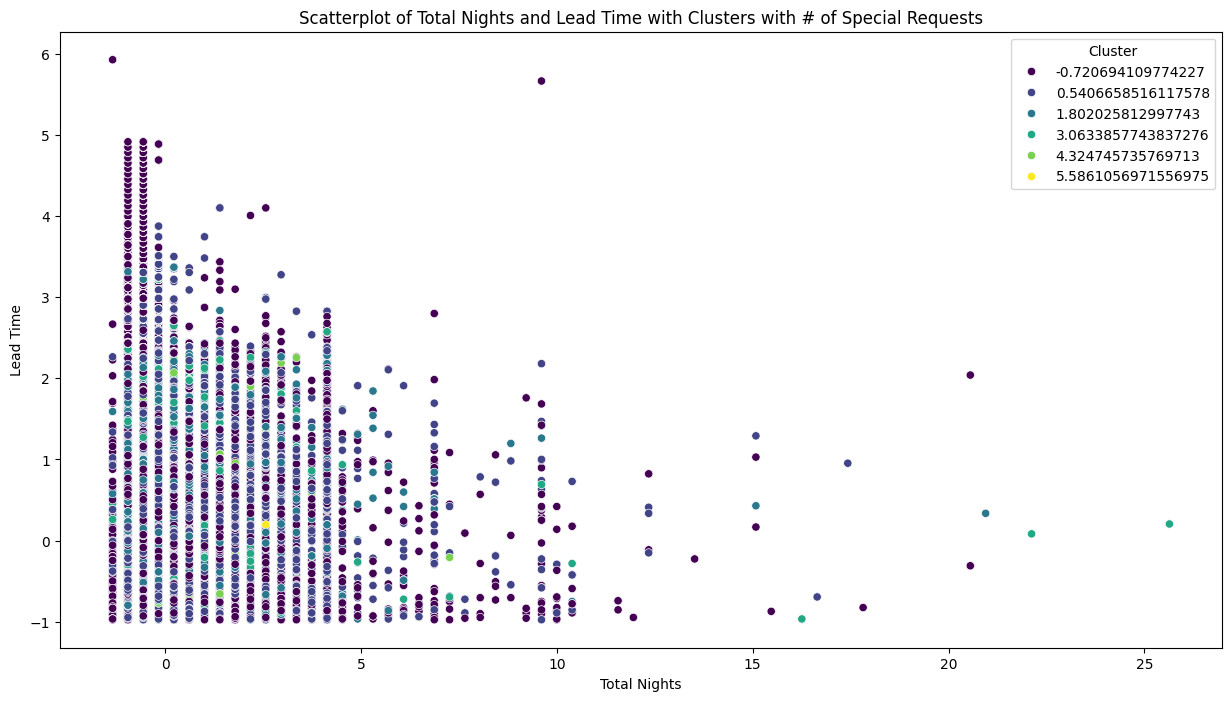


Average by Cluster: 
          total_nights  lead_time  total_of_special_requests
cluster                                                    
0           -0.276621  -0.457236                  -0.720694
1           -0.073105  -0.383764                   1.093283
2            0.602002   1.389943                  -0.359569


In [45]:
plt.figure(figsize = (15, 8))
sns.scatterplot(data = segment_scaled, x = 'total_nights', y = 'lead_time', hue = 'total_of_special_requests', palette = 'viridis')
plt.xlabel('Total Nights')
plt.ylabel('Lead Time')
plt.legend(title = 'Cluster')
plt.title('Scatterplot of Total Nights and Lead Time with Clusters with # of Special Requests')
plt.show()

cluster_avg = segment_scaled.groupby('cluster')[new_features].mean()
print('\nAverage by Cluster: \n', cluster_avg)

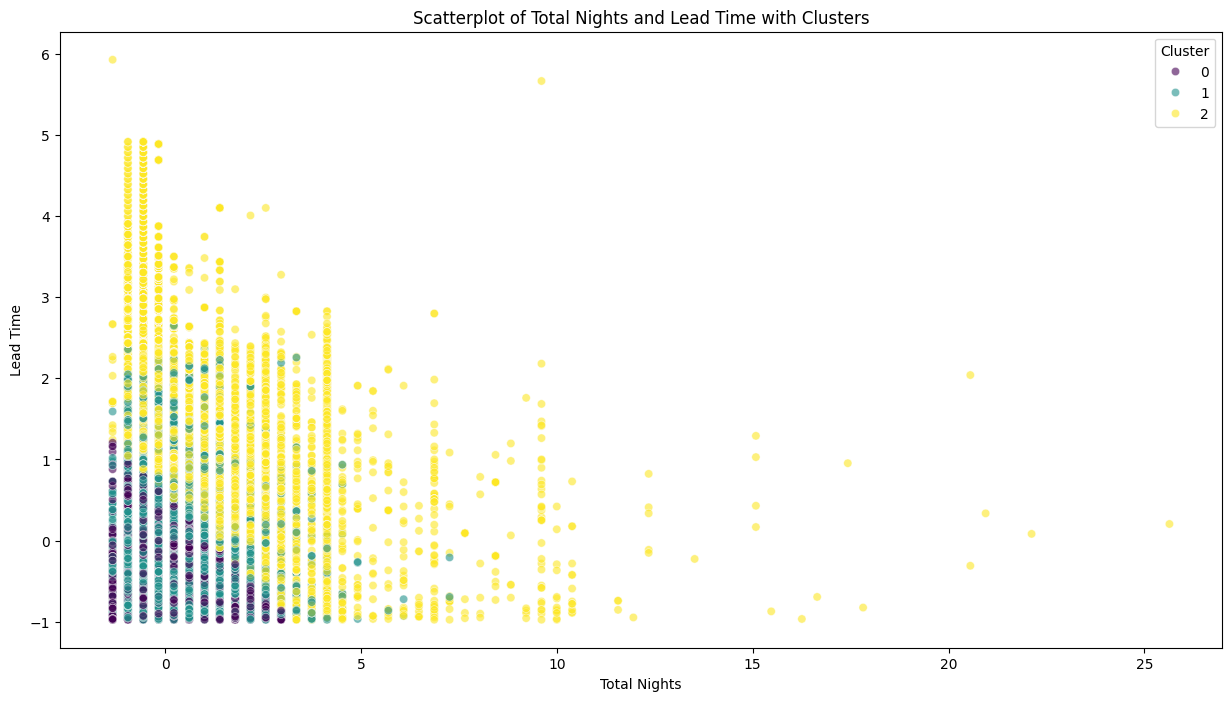

In [46]:
plt.figure(figsize = (15, 8))
sns.scatterplot(data = segment_scaled, x = 'total_nights', y = 'lead_time', hue = 'cluster', palette = 'viridis', alpha = 0.6)
plt.xlabel('Total Nights')
plt.ylabel('Lead Time')
plt.legend(title = 'Cluster')
plt.title('Scatterplot of Total Nights and Lead Time with Clusters')
plt.show()

### ✍️ Your Response: 🔧
1. I chose a k value of three because customers tend to mess with their bookings less because they/just stay for a less amount of time, those that stay for a long time and therefore are more particular with them, and those in the middle.

2. There is a lot of overlap, but from what I can tell there are those that stay for less time that those who make the least amount of special requests stay for the shortest time, but can also have long lead times.


## 4. Apply Gaussian Mixture Model (GMM)

Business framing:  

Not all guests fit neatly into one cluster. GMM lets us capture uncertainty — useful if customers behave similarly across groups.

- Fit a GMM with the same number of clusters you chose in Part 3
- Predict soft clusters (remember that soft clustering deals with probabilities, not labels)
- Visualize the GMM model so that you may compare it to the KMeans scatterplot

### In Your Response:
1. How did the GMM results compare to KMeans?
2. What business questions might GMM help answer better?


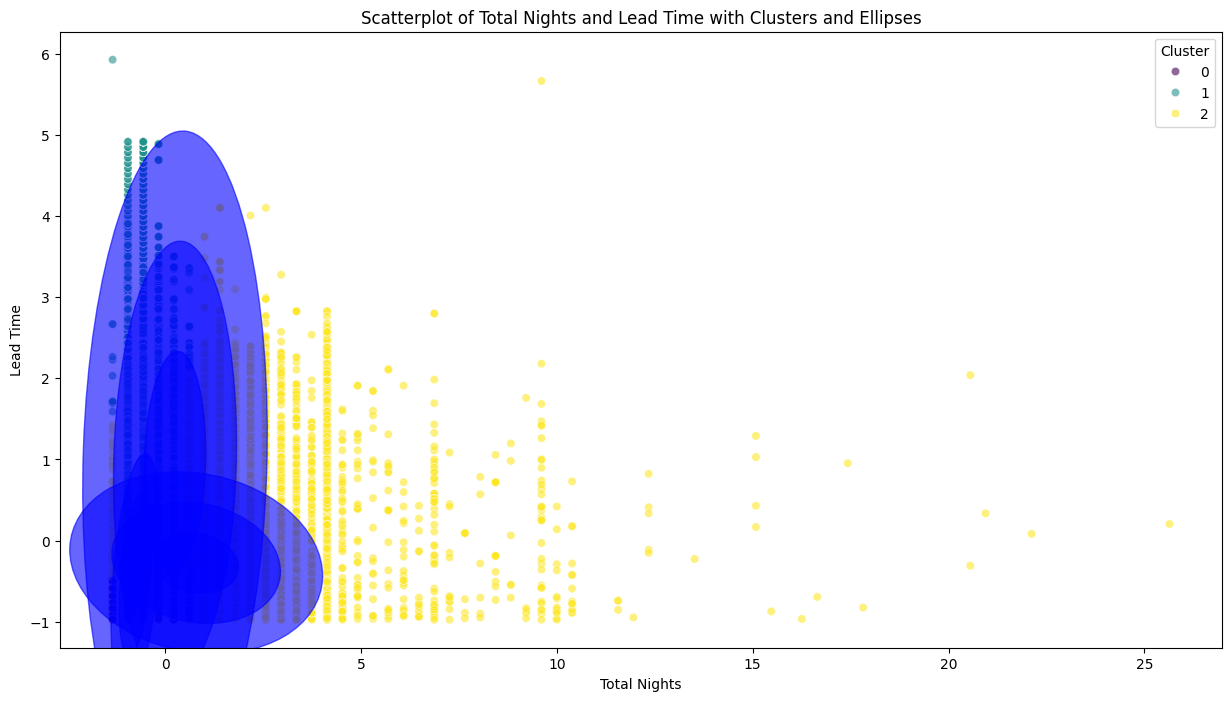


Average by GMMCluster: 
              total_nights  lead_time  total_of_special_requests
gmm_cluster                                                    
0               -0.408763  -0.759346                   0.053178
1               -0.271109   0.836546                  -0.149814
2                1.429676   0.289717                   0.140781


In [47]:
from re import S
# Add your code here
gmm = GaussianMixture(n_components = 3, random_state = 1)
gmm.fit(x_features[['lead_time', 'total_nights']])

gmm_probs = gmm.predict_proba(x_features[['lead_time', 'total_nights']])
segment_scaled['gmm_cluster'] = np.argmax(gmm_probs, axis = 1)

plt.figure(figsize = (15, 8))
ax = sns.scatterplot(data = segment_scaled, x = 'total_nights', y = 'lead_time', hue = 'gmm_cluster', palette = 'viridis', alpha = 0.6)

def draw_ellipse(position, covariance, ax, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    U, S, Vt = np.linalg.svd(covariance)
    angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
    width, height = 2 * np.sqrt(S)

    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle=angle, **kwargs)) # Pass angle as keyword argument

means = gmm.means_
covariances = gmm.covariances_

for i in range(means.shape[0]):
    draw_ellipse(means[i], covariances[i], ax, alpha = 0.6, color = "blue")

plt.xlabel('Total Nights')
plt.ylabel('Lead Time')
plt.legend(title = 'Cluster')
plt.title('Scatterplot of Total Nights and Lead Time with Clusters and Ellipses')
plt.show()

gmm_cluster_avg = segment_scaled.groupby('gmm_cluster')[new_features].mean()
print('\nAverage by GMMCluster: \n', gmm_cluster_avg)

### ✍️ Your Response: 🔧
1. The GMM was better to see and visualize, but the groups were still heavily  overlapping.

2. GMM might help answer the business question of whether there is a need to segment the customers, and to what degree if so. If there is a need, another follow up question is how many segements are needed.


## 5. Evaluate Your Models

Business framing:  

In business, models should be both useful and reliable. You’ll compare model quality using standard evaluation metrics.

- Calculate:
  - WCSS
  - Silhouette Score
  - Davies-Bouldin Index
- Compare both models

**Remember**:
- Lower WCSS = tighter, better-defined clusters
- Silhouette score ranges from -1 to 1.  Higher values = better clustering
- Lower Davies-Boulding Index = better clustering

### In Your Response:
1. Which model performed better on the metrics?
2. Would you recommend KMeans or GMM for a business analyst? Why?


In [48]:
# Add code here 🔧
wcss = []

kmeans = KMeans(n_clusters = 3, random_state = 1, n_init=10)
kmeans.fit(x_features)
wcss.append(kmeans.inertia_)
print('WCSS: ', wcss)

silhouette_kmeans = silhouette_score(x_features, segment_scaled['cluster'])
print('Silhouette Score KMeands: ', silhouette_kmeans)

davies_bouldin_kmeans = davies_bouldin_score(x_features, segment_scaled['cluster'])
print('Davies-Bouldin Index KMeans: ', davies_bouldin_kmeans)

silhouette_gmm = silhouette_score(x_features, segment_scaled['gmm_cluster'])
print('Silhouette Score GMM: ', silhouette_gmm)

davies_bouldin_gmm = davies_bouldin_score(x_features, segment_scaled['gmm_cluster'])
print('Davies-Bouldin Index GMM: ', davies_bouldin_gmm)

WCSS:  [194183.72384692213]
Silhouette Score KMeands:  0.3471098745493333
Davies-Bouldin Index KMeans:  1.1022688051222402
Silhouette Score GMM:  0.24731476248397555
Davies-Bouldin Index GMM:  1.5124031608257458


### ✍️ Your Response: 🔧
1. The KMM model had better clustering, as it had a higher Silhouette Score and lower Davies Index.

2. KMM uses less computational power, so its good for faster, more equal clustering and for one segment. If the analyst wants overlapping segments, then GMM is better to handle exomplex data.


## 6. Business Interpretation

Business framing:  

What do these clusters mean in the real world? Could they represent solo travelers, families, or bargain shoppers?

- Review characteristics of each cluster (e.g. average `lead_time`, `special_requests`)
- Think from a marketing or hotel operations perspective

### In Your Response:
1. What do the segments represent in terms of guest behavior?
2. How could the hotel tailor services or promotions to each group?


In [49]:
# Add code here 🔧
df['cluster'] = segment_scaled['cluster']

df['gmm_cluster'] = segment_scaled['gmm_cluster']

print("Avg Characteristics by KMeans: ")
print(df.groupby('cluster')[new_features].mean())

print("\nAvg Characteristics by GMM: ")
print(df.groupby('gmm_cluster')[new_features].mean())

Avg Characteristics by KMeans: 
         total_nights   lead_time  total_of_special_requests
cluster                                                     
0            2.720461   55.149916                   0.000000
1            3.240939   63.001361                   1.438112
2            4.967476  252.544411                   0.286298

Avg Characteristics by GMM: 
             total_nights   lead_time  total_of_special_requests
gmm_cluster                                                     
0                2.382518   22.865717                   0.613522
1                2.734557  193.406982                   0.452591
2                7.084193  134.971381                   0.682974


### ✍️ Your Response: 🔧
1. In regards to guest behavior, cluster 0 represents cutomers last minute, stays for little time, and makes moderate booking requests. Customers in cluster 1 book for a moderate time and  make more special requests. Customers in cluster 2 stay for a longer time and book far in advance with few special requests.

2. For cluster 0, hotels can advertise their conference centers or work related facilities. For cluster 1 they can advertise their tourist packages. For cluster 2 they can advertise special promotions for longer stays.


## 7. Final Reflection

Business framing:  

Many teams ask for "segmentation" without knowing how it works. You now have hands-on experience with two clustering techniques and how to present the results.

### In Your Response:
1. What was most challenging about unsupervised learning?
2. When would you use clustering instead of supervised models?
3. How would you explain the value of clustering to a non-technical manager?
4. How does this relate to your customized learning outcome you created in canvas?


### ✍️ Your Response: 🔧
1. The most challenging part of unsupervised learning was figuring out the best ways to cluster and getting insightful results that can be actually used to make decisions.

2. You would use clustering instead of supervised models when you have a huge amount of data, and you want to see groupings that may be hard to see otherwise.

3. I would explain than clustering allows for decision makers to see where to focus strategy, and what varibales to guide further research.

4. This relates to my customized learning outcome because clustering helps make better and more informed decisions for operational strategy.

## Submission Instructions

✅ **Before submitting:**
- Make sure all code cells are run and outputs are visible  
- All markdown questions are answered thoughtfully  
- Submit the assignment as an **HTML file** on Canvas


In [52]:
!jupyter nbconvert --to html "assignment_09_AndradeLeslie.ipynb"

[NbConvertApp] Converting notebook assignment_09_AndradeLeslie.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 3 image(s).
[NbConvertApp] Writing 1096306 bytes to assignment_09_AndradeLeslie.html
